# Imports

In [1]:
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
CUDA_VISIBLE_DEVICES=""

try:
    import google.colab
    from google.colab import drive
    drive.mount('/content/drive')
    base_dir = '/content/drive/MyDrive/thesis/'
    os.chdir(base_dir + 'code/nieuw/train_predict')
except:
    IN_COLAB = False

In [2]:
if IN_COLAB:
    # This is handled seperately in colab
    !{sys.executable} -m pip install optuna -q
    !pip install wandb -qU

os.environ["WANDB_START_METHOD"] = "thread"

In [3]:
# %%writefile main.py
import wandb
import sys
import importlib
import torch
import numpy as np
import math

import_files = ["config", "dataset", "experiments", "helpers", "losses", "model", "predict", "train"]

# this hack is needed, in case changes are made to the underlying python files
for file in import_files:
    module = importlib.import_module(file)
    importlib.reload(module)
    globals()[file] = module

# from train import train
from losses import FocalLoss
from dataset import load_data, prepare_data, CustomDataHandler, CustomDataset
from experiments import Experiment, FeatureExtractExperiment, FineTuneExperiment, SideTuneExperiment
from helpers import calculate_metrics, calculate_focal_alpha, show_confusion_matrix, generate_test_stats, get_confusion_matrix
from config import alpha, gamma, num_epochs, batch_size, hidden_size, lr, start_date, val_size, batch_size, test_year, apply_scaler, apply_smote, val_type, drop, weight_decay, val_year, config
from predict import predict, show_predictions
from model import SideTuneWrapper, NeuralNetwork

# Importing and preprocessing data

In [4]:
# Set the random seed for reproducibility
if IN_COLAB:
    base_dir = '/content/drive/MyDrive/thesis/'
else:
    base_dir = 'C:/Users/20183061/OneDrive - TU Eindhoven/Documents/master_dsai/thesis/'
folder = 'data/preprocessed/'
torch.manual_seed(1)

file = 'result_imputed.csv'

# loading the data into two datahandlers from the csv
chi_handler, ort_handler = load_data(file = base_dir + folder + file,
                                     start_date = start_date,
                                     val_size = val_size,
                                     batch_size = batch_size,
                                     frac_train = 1)

# running the preparation steps for both handlers, like scaling, train_test_val splits
prepare_data([chi_handler, ort_handler], test_year = test_year, val_type = val_type, val_year= val_year, apply_scaler = apply_scaler, apply_smote = apply_smote,
             select_features = [
      'Opnameleeftijd',
      'Geslacht',
      "ASA_score",
      "Dyspnoe_score",
      "BMI_score",
      'SES',
    # The code was redeveloped so features with the prefix of MED, DBC, ICD would be automatically selected.
      'unique_departments'
      ])

# choose a handler to train with.
train_class = 'ORT'
handler = ort_handler

C:\Users\20183061\OneDrive - TU Eindhoven\Documents\master_dsai\thesis\code\train_predict\train_predict\dataset.py:137: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_prep['Opname jaar'] = pd.to_datetime(df_prep['OpnameDatumTijd']).dt.year


Opnameleeftijd        0
Geslacht              0
ASA_score             0
Dyspnoe_score         0
BMI_score             0
SES                   0
unique_departments    0
MED_N05               0
MED_N02               0
MED_H02               0
MED_J01               0
MED_A02               0
MED_C10               0
MED_B01               0
MED_R01               0
MED_C09               0
MED_A10               0
MED_B05               0
MED_A03               0
MED_A04               0
ICD_M16               0
ICD_M17               0
ICD_S72               0
ICD_T84               0
ICD_S82               0
ICD_F05               0
ICD_T14               0
ICD_M19               0
ICD_S42               0
ICD_I73               0
ICD_K81               0
ICD_R10               0
ICD_K37               0
ICD_K35               0
ICD_K57               0
ICD_K80               0
ICD_K56               0
DBC_1701.0            0
DBC_1801.0            0
DBC_3019.0            0
DBC_1350.0            0
DBC_1703.0      

# Experiments

In [200]:
# WandB is a tool used for storing results of tests
# Here we log into WandB
use_wandb = True
if use_wandb:
    wandb.login()

# 12975bda3011933073ed197abceea44999cd634f

In [ ]:
import numpy as np
from experiments import generate_experiments, Sweep

experiment_types  = [Experiment, FeatureExtractExperiment, FineTuneExperiment, SideTuneExperiment]

experiments = generate_experiments(experiment_types, chi_handler, ort_handler, config, duplicates=1)

for i, experiment in enumerate(experiments):
    print(f"{i}==========================================")
    experiment.run_experiment(False, show_visuals= True, sweep=False, use_profiler=False)

    experiment.save_model(f"name{i}")

# instead, a single experiment can be run as follows:
# custom_experiment = Experiment(ort_handler, config, duplicates=1)


The code below does the sweeps



In [ ]:
# sys.exit()
from experiments import generate_experiments, Sweep
from config import sweep_parameters
from config import parameters_bayesian

sweep_config = {
    'name' : 'sweep_5',
    'method': 'bayes'
}

metric = {
  'name': 'val_loss',
  'goal': 'minimize'
}

# split it up into running 4 different tests for each of the strategies.
for experiment_type in ['regular', 'sidetune', 'featureextract', 'finetune']:
    print(f'sweep{experiment_type}')
    parameters_bayesian['experiment_type']['values'] = [experiment_type]

    # set up a sweep class, the parameters are found in config.py
    sweep_instance = Sweep(
        ort_handler, chi_handler,
        sweep_config, parameters_bayesian,
        metric, project="Thesis_Final")
    sweep_instance.run()

# Load the best models for test analysis

For each of these, the best performing model has been chosen according to the wandb sweep results. Then, a sample threshold is chosen, to calculate the final test confusion matrix.

In [ ]:
from model import FlexibleNeuralNetwork
import torch
import pandas as pd
from helpers import build_pr_curve

for model_type, number in [
# place the iteration which resulted in the best result in here, for analysis.
    ('regular',        '483'),
    ('featureextract', '69' ),
    ('finetune',       '283'),
    ('sidetune',       '8'  )]:
    print(f"from here {model_type} {number} ================")
    
    best_model = torch.load(f"saved_models/{model_type}_{number}.pth")
    best_model.eval()

    # this line can be ran for indication
    # _, _, _, _, _, _, pr_auc = build_pr_curve(best_model_regular, ort_handler, debug=True, on ='test')
    precision, recall, thresholds, best_precision, best_recall, val_threshold, _ = build_pr_curve(best_model, ort_handler, debug=True, on ='val')
    
    # Save precision, recall, and thresholds to a CSV, to load in overleaf for visualization
    data = {
        'Recall': recall,
        'Precision': precision,
        # For some reason you need to add a 1 to the thresholds
        'Threshold': np.append(thresholds, 1)
    }

    df = pd.DataFrame(data)
    df.to_csv(f'data_pr/{model_type}_pr.csv', index=False)

    # Optionally, save the best point data
    best_point = {
        'Best Recall': best_recall,
        'Best Precision': best_precision,
        'Best Threshold': best_threshold,
        'Best auc': pr_auc
    }

    best_df = pd.DataFrame([best_point])
    best_df.to_csv(f'data_pr/{model_type}_pr_point.csv', index=False)

    # show the test statistics for the model
    _, _ = generate_test_stats(best_model, ort_handler, val_threshold, on='test')



# From here we get into the full cases analysis

In [33]:
folder = 'data/preprocessed/'
torch.manual_seed(1)
file = 'ORT_complete_cases.csv'

# load the complete cases csv
chi_full_handler, ort_full_handler = load_data(file = base_dir + folder + file,
                                     start_date = start_date,
                                     val_size = val_size,
                                     batch_size = batch_size,
                                     frac_train = 1)
# run the preprocessing steps
prepare_data([chi_full_handler, ort_full_handler], test_year = test_year, val_type = val_type, val_year= val_year, apply_scaler = apply_scaler, apply_smote = apply_smote,
             select_features = [
      'Opnameleeftijd',
      'Geslacht',
      "ASA_score",
      "Dyspnoe_score",
      "BMI_score",
      'SES',
    # The code was redeveloped so features with the prefix of MED, DBC, ICD would be automatically selected.
      'unique_departments'
      ])

C:\Users\20183061\OneDrive - TU Eindhoven\Documents\master_dsai\thesis\code\train_predict\train_predict\dataset.py:137: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_prep['Opname jaar'] = pd.to_datetime(df_prep['OpnameDatumTijd']).dt.year


Opnameleeftijd        0
Geslacht              0
ASA_score             0
Dyspnoe_score         0
BMI_score             0
SES                   0
unique_departments    0
MED_N02               0
MED_J01               0
MED_C10               0
MED_N05               0
MED_B01               0
MED_R01               0
MED_B05               0
MED_C09               0
MED_H02               0
MED_A10               0
MED_A02               0
MED_A03               0
MED_A04               0
ICD_M16               0
ICD_M17               0
ICD_S72               0
ICD_S82               0
ICD_T84               0
ICD_F05               0
ICD_M19               0
ICD_T14               0
ICD_S42               0
ICD_I73               0
ICD_K81               0
ICD_R10               0
ICD_K37               0
ICD_K35               0
ICD_K57               0
ICD_K80               0
ICD_K56               0
DBC_1701              0
DBC_1801              0
DBC_3019              0
DBC_1350              0
DBC_1703        

In [ ]:
from helpers import build_pr_curve
best_model_regular = torch.load("saved_models/sidetune_8.pth")

# generate the pr curve
precision, recall, thresholds, best_precision, best_recall, best_threshold, pr_auc = build_pr_curve(best_model_regular, ort_full_handler, debug=True)

min_acc, maj_acc = generate_test_stats(best_model_regular, ort_full_handler, best_threshold)

# Save precision, recall, and thresholds to a CSV
data = {
    'Recall': recall,
    'Precision': precision,
    # For some reason you need to add a 1 to the thresholds
    'Threshold': np.append(thresholds, 1)
}

df = pd.DataFrame(data)
df.to_csv('data_pr/full_case_pr.csv', index=False)

# Optionally, save the best point data
best_point = {
    'Best Recall': best_recall,
    'Best Precision': best_precision,
    'Best Threshold': best_threshold,
    'Best AUC' : pr_auc
}

best_df = pd.DataFrame([best_point])
best_df.to_csv('data_pr/full_case_pr_point.csv', index=False)

# Logistic Regression

A logistic Regression is run to have a baseline

In [8]:
from dataset import get_fulldata_from_loader

X_train, y_train = get_fulldata_from_loader(ort_handler.train_loader)
X_test, y_test = get_fulldata_from_loader(ort_handler.test_loader)


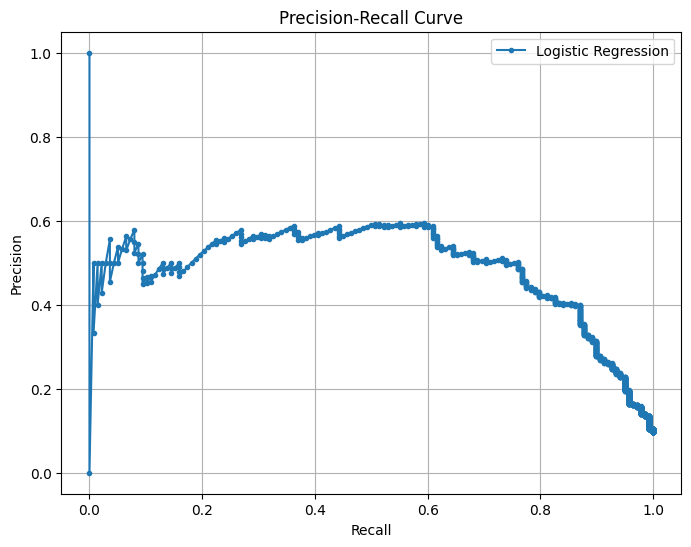

logistic regression AUC:0.4853309721592783
best precision/recall is 0.5023923444976076, 0.7608695652173914


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

logreg = LogisticRegression(class_weight='balanced', random_state=42)
logreg.fit(X_train, y_train)#, sample_weight=np.where(y_train == 1, 3, 1))

# hier stond de sample weight ingesteld op 3 en dat werkt best goed?
logreg.fit(X_train, y_train, sample_weight=np.where(y_train == 1, 3, 1))


logreg.score(X_test, y_test)

y_scores = logreg.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Step 6: Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

pr_auc = auc(recall, precision)
print(f"logistic regression AUC:{pr_auc}")

distances = np.sqrt((1 - recall) ** 2 + (1 - precision) ** 2)
best_index = np.argmin(distances)
best_precision = precision[best_index]
best_recall = recall[best_index]
best_threshold = thresholds[best_index] if best_index < len(thresholds) else None
print(f"best precision/recall is {best_precision}, {best_recall}")

In [109]:
import pandas as pd

# Save precision, recall, and thresholds to a CSV
data = {
    'Recall': recall,
    'Precision': precision,
    # For some reason you need to add a 1 to the thresholds
    'Threshold': np.append(thresholds, 1)
}

df = pd.DataFrame(data)
df.to_csv('data_pr/log_pr.csv', index=False)

# Optionally, save the best point data
best_point = {
    'Best Recall': best_recall,
    'Best Precision': best_precision,
    'Best Threshold': best_threshold,
    'Best AUC' : pr_auc
}

best_df = pd.DataFrame([best_point])
best_df.to_csv('data_pr/log_pr_point.csv', index=False)


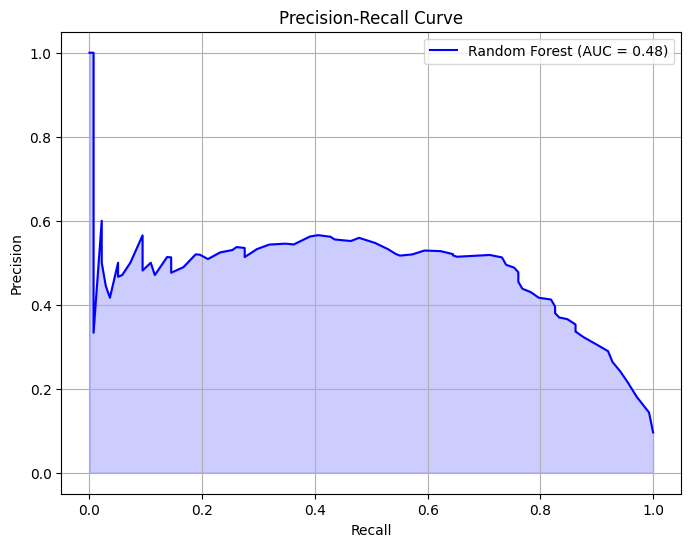

logistic regression AUC:0.4754171641696741
best precision/recall is 0.5126903553299492, 0.7318840579710145


In [110]:
from sklearn.ensemble import RandomForestClassifier
# Initialize and train a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# Predict probabilities for the positive class (class 1)
y_prob = rf.predict_proba(X_test)[:, 1]

# Calculate Precision-Recall curve values
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Calculate AUC (Area Under the Curve)
auc_score = auc(recall, precision)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'Random Forest (AUC = {auc_score:.2f})')
plt.fill_between(recall, precision, color='blue', alpha=0.2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

pr_auc = auc(recall, precision)
print(f"logistic regression AUC:{pr_auc}")

distances = np.sqrt((1 - recall) ** 2 + (1 - precision) ** 2)
best_index = np.argmin(distances)
best_precision = precision[best_index]
best_recall = recall[best_index]
best_threshold = thresholds[best_index] if best_index < len(thresholds) else None
print(f"best precision/recall is {best_precision}, {best_recall}")

In [111]:
import pandas as pd

# Save precision, recall, and thresholds to a CSV
data = {
    'Recall': recall,
    'Precision': precision,
    # For some reason you need to add a 1 to the thresholds
    'Threshold': np.append(thresholds, 1)
}

df = pd.DataFrame(data)
df.to_csv('data_pr/rfc_pr.csv', index=False)

# Optionally, save the best point data
best_point = {
    'Best Recall': best_recall,
    'Best Precision': best_precision,
    'Best Threshold': best_threshold,
    'Best auc': pr_auc
}

best_df = pd.DataFrame([best_point])
best_df.to_csv('data_pr/rfc_pr_point.csv', index=False)


# SHAP analysis of models

In [65]:
import torch

def get_representative_sample(X, y, n):
    """
    Get a representative sample from X and y, maintaining the class distribution.
    Majority class cases are placed first, followed by minority class cases.

    Parameters:
        X (torch.Tensor): Feature tensor.
        y (torch.Tensor): Binary label tensor (0 for majority, 1 for minority).
        n (int): Total number of samples to select.

    Returns:
        (torch.Tensor, torch.Tensor): Sampled X and y tensors.
    """
    # Separate indices for majority (maj) and minority (min) classes
    maj_indices = torch.where(y == 0)[0]
    min_indices = torch.where(y == 1)[0]

    # Calculate number of samples for each class based on the original distribution
    total_maj = len(maj_indices)
    total_min = len(min_indices)
    proportion_maj = total_maj / len(y)
    proportion_min = total_min / len(y)

    n_maj = int(n * proportion_maj)
    n_min = n - n_maj  # Ensure total equals n

    # Sample indices for each class
    sampled_maj_indices = maj_indices[torch.randperm(total_maj)[:n_maj]]
    sampled_min_indices = min_indices[torch.randperm(total_min)[:n_min]]

    # Combine sampled indices
    sampled_indices = torch.cat([sampled_maj_indices, sampled_min_indices])

    # Sort to keep majority (maj) first, then minority (min)
    sampled_indices = sampled_indices[torch.argsort(y[sampled_indices])]

    # Extract sampled X and y
    X_sampled = X[sampled_indices]
    y_sampled = y[sampled_indices]

    return X_sampled, y_sampled

In [66]:
X_sampled, y_sampled = get_representative_sample(X_train, y_train, 200)

background_sample = X_sampled

In [80]:
# imports
import matplotlib.pyplot as plt
import seaborn as sns
import shap

shap.initjs()

dataloader  = custom_experiment.side_handler.val_loader
model       = custom_experiment.model

model.eval()
X, y = get_fulldata_from_loader(dataloader)
y = y.detach().cpu().numpy()  # Move to CPU and convert to NumPy array
f_a = np.array(custom_experiment.side_handler.features)

translation_dict = {
    "Opnameleeftijd" : "Age",
    "Geslacht": "Gender",
    "BMI_score": "BMI",
    "ASA_score": "ASA",
    "Dyspnoe_score": "Dyspnoea",
    "unique_departments":"Unique Departments"
}

f_a = [translation_dict.get(feature, feature) for feature in f_a]


torch.Size([2426, 55])
(2426,)
['Age', 'Gender', 'ASA', 'Dyspnoea', 'BMI', 'SES', 'Unique Departments', 'MED_N05', 'MED_N02', 'MED_H02', 'MED_J01', 'MED_A02', 'MED_C10', 'MED_B01', 'MED_R01', 'MED_C09', 'MED_A10', 'MED_B05', 'MED_A03', 'MED_A04', 'ICD_M16', 'ICD_M17', 'ICD_S72', 'ICD_T84', 'ICD_S82', 'ICD_F05', 'ICD_T14', 'ICD_M19', 'ICD_S42', 'ICD_I73', 'ICD_K81', 'ICD_R10', 'ICD_K37', 'ICD_K35', 'ICD_K57', 'ICD_K80', 'ICD_K56', 'DBC_1701.0', 'DBC_1801.0', 'DBC_3019.0', 'DBC_1350.0', 'DBC_1703.0', 'DBC_1803.0', 'DBC_1401.0', 'DBC_3004.0', 'DBC_1820.0', 'DBC_323.0', 'DBC_113.0', 'DBC_420.0', 'DBC_129.0', 'DBC_418.0', 'DBC_327.0', 'DBC_318.0', 'DBC_333.0', 'DBC_218.0']
torch.Size([200, 55])


In [68]:
def model_log_odds(sample):
    tensor = torch.from_numpy(sample).float().to('cuda')
    logits = model(tensor)
    logits = logits.to('cpu')
    
    softmax_probs = torch.sigmoid(logits)

    log_odds = torch.log(softmax_probs / (1-softmax_probs))
    log_odds = log_odds[:,0]
    return log_odds.cpu().detach().numpy()

# Create the SHAP explainer
explainer = shap.KernelExplainer(model_log_odds, background_sample.numpy(), feature_names=f_a)

# Generate SHAP values for a subset of inputs
subset = 200  # Choose a subset of inputs to explain

X, y = get_representative_sample(X, y, 200)

shap_values = explainer(X[:subset])


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

In [71]:
# Optionally, apply inverse transformation to SHAP values (if you have a scaler)
print(type(shap_values.data))

data_array = np.array(shap_values.data)
data_array = data_array.squeeze()
print(data_array.shape)
shap_values.data = custom_experiment.side_handler.get_inverse_scaler(data_array)

<class 'numpy.ndarray'>
(200, 55)


In [72]:
# # Assuming shap_values_squeezed is the reshaped SHAP values
shap_values_explanation = shap.Explanation(
    shap_values,  # The reshaped SHAP values
    y[:subset],  # The input features (numpy array)
    feature_names=[f_a]*subset  # The feature names
)

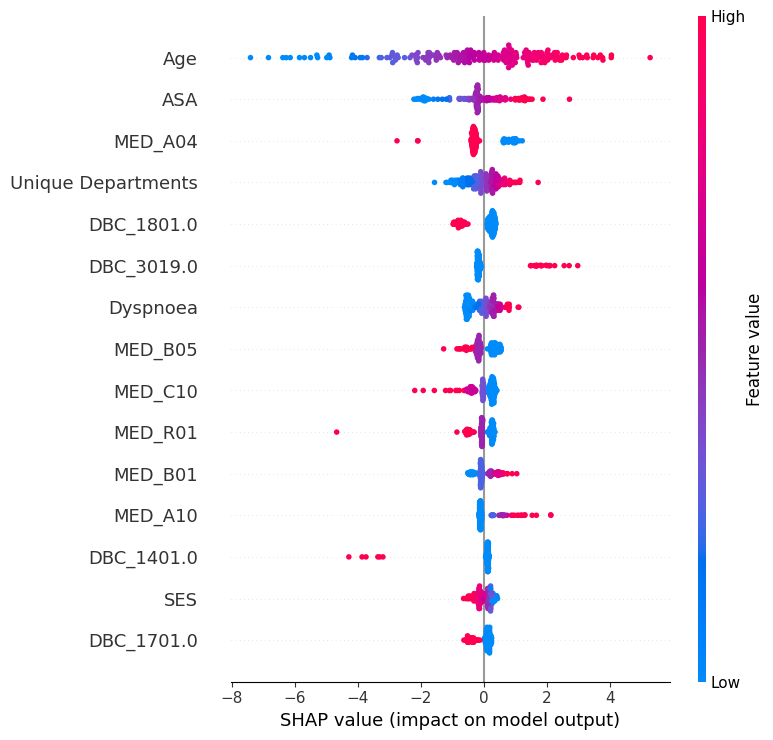

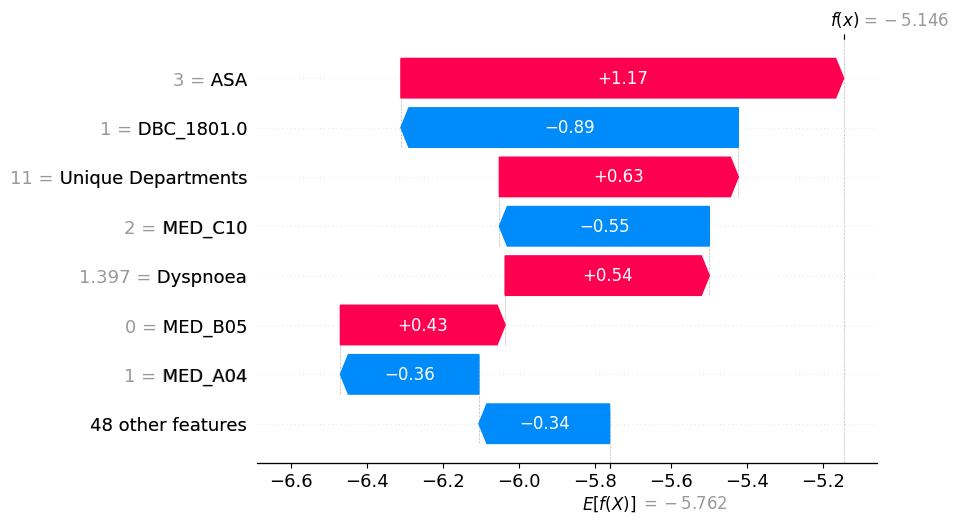

In [79]:
visualize_shap = True
if visualize_shap:
    shap.summary_plot(shap_values[:, :], X[:subset], sort=True, feature_names =f_a ,max_display=15)

    shap.plots.waterfall(shap_values[1], max_display =8)

    # scatter and other can be used for further analysis
    # shap.plots.scatter(shap_values[:, "N02"])
#     shap.plots.bar(shap_values, max_display=60)
#     shap.plots.beeswarm(shap_values, max_display=60)


In [222]:
# very small calculator to interpret the log results.
testthis= -7.831
print(math.e**(testthis)/ (1+math.e**(testthis)))

# Calibration curve code

In [131]:
import pandas as pd
from predict import predict_raw
from sklearn.calibration import calibration_curve

y_pred = predict_raw(model, X)

n_bins = 10

prob_true, prob_pred = calibration_curve(y, y_pred, n_bins=n_bins)

unscaled_data = custom_experiment.side_handler.get_inverse_scaler(X)

df = pd.DataFrame(unscaled_data, columns=f_a)

df['y_true'] = y
df['y_pred'] = y_pred

# unscaled_data[:,0] refers to the age column, and [:, 1] to gender
df['age_group'] = np.where(unscaled_data[:,0] < 70, 'under_70', '70_and_older')
df['gender']    = np.where(unscaled_data[:,1] < 0.5, 'female', 'male')

In [ ]:
groups = [
    ('Under 70', df['age_group'] == 'under_70'),
    ('70 and Older', df['age_group'] == '70_and_older'),
    ('Male', df['gender'] == 'male'),
    ('Female', df['gender'] == 'female')
]

fig, ax = plt.subplots()

# Loop through groups and plot calibration curves
for label, condition in groups:
    print(f"starting {label}, condition {condition}")
    group_data = df[condition]
    print(group_data)
    prob_true, prob_pred = calibration_curve(group_data['y_true'], group_data['y_pred'], n_bins=n_bins)
    ax.plot(prob_pred, prob_true, marker='o', label=f"Group: {label}")

a, b = calibration_curve(y, y_pred, n_bins=n_bins)
ax.plot(b, a,  marker='o', label="Full population")
    
# Add perfect calibration line
ax.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")

ax.set_xlim([0, 1])  # For x-axis
ax.set_ylim([0, 1])  # For y-axis

ax.set_aspect('equal', 'box')

# Configure the plot
ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Fraction of positives")
ax.set_title("Grouped Calibration Plot")
ax.legend(loc="best")
# ax.grid()
plt.show()

In [ ]:
import matplotlib as mpl
mpl.rcParams['pgf.texsystem'] = 'pdflatex'

fig.savefig("Grouped_calibration_plot.pgf", format='pgf')